In [1]:
import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install scipy
!{sys.executable} -m pip install seaborn
!{sys.executable} -m pip install networkx
!{sys.executable} -m pip install graphviz
!{sys.executable} -m pip install pydot

In [2]:
from IPython.display import Latex, Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import bernoulli, norm, binom
import seaborn as sns
import networkx as nx
import graphviz
import os
import urllib

<p class="gap2">
<h1 style="color: #ed9041">Advertising, Algorithms and Privacy: <br>
Recent Open-source Developments</h1>

<h2 style="color: #667b83">Or actually only differential privacy</h2>


<p class="gap05">  </p>
<h3 style="color: #459db9">Ruben Mak <br>
Head of Data Science at Greenhouse</h3>
<img src="images/pydata_eindhoven.jpeg">
</p>

## Open-source Contributions from Advertising Companies
* Google: Tensorflow
* Facebook: Torch
* Greenhouse: https://pypi.org/user/marvin.ng/

<p><img src="images/marvin.ng.png"></p>

## AI - Privacy trade-off
* Great value from current data explosion and algorithms
* But how to balance against privacy concerns?

## When is data anonymous?

<p><img src='images/imdb_netflix.png'></p>

* [How To Break Anonymity of the Netflix Prize Dataset](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.100.3581&rep=rep1&type=pdf)
* [De-anonymization of Netflix Reviews using Amazon Reviews](https://courses.csail.mit.edu/6.857/2018/project/Archie-Gershon-Katchoff-Zeng-Netflix.pdf)

## Machine learning example

<p><img src='images/model_inversion_attack.png' width="500" height="600"></p>

* [Model Inversion Attacks that Exploit Confidence Information](https://www.cs.cmu.edu/~mfredrik/papers/fjr2015ccs.pdf)

## Differential Privacy

* How can we quantify privacy?
* [Cynthia Dwork 2006, Microsoft Research](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/dwork.pdf)

<p><img src='images/dwork_2006.png' width="800" height="600"></p>


## The Differential Privacy Guarantee

* But what does this mean?

<p><img src='images/differential_privacy_guarantee.png' width="900" height="700"></p>

* [Differential Privacy: a Primer for Non-Technical People](https://privacytools.seas.harvard.edu/files/privacytools/files/pedagogical-document-dp_new.pdf)

## The Privacy Budget

<p><img src='images/privacy_budget.png' width="900" height="700"></p>

Why?

If $Pr[f(D_1)] \leq exp(\epsilon_f) * Pr[f(D_2)]$ and $Pr[g(D_1)] \leq exp(\epsilon_g) * Pr[g(D_2)]$ then

$Pr[h(f(D_1),g(D_1))] \leq exp(\epsilon_f + \epsilon_g) * Pr[h(f(D_2),g(D_2))]$

<p><img src='images/google_is_opensourcing.png'></p>

* This talk will focus on this open-source contribution
* We focus on global differential privacy: user level data is stored in central database
* The opposite is local differential privacy: e.g. the data is made differentially private before it leaves the device of the user [Example: RAPPOR](https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/42852.pdf)
* [Google Announcement](https://developers.googleblog.com/2019/09/enabling-developers-and-organizations.html)
* [Technical paper Google](https://arxiv.org/pdf/1909.01917.pdf)
* [Uber open-sourcing differentially private SQL](https://users.cs.duke.edu/~ashwin/pubs/PrivateSQL-VLDB2019.pdf)
* [Microsoft on differentially private SQL](https://www.microsoft.com/en-us/research/video/private-sql-a-differentially-private-sql-query-engine/)

## What mechanism can we use to achieve this?

By adding noise to the results, using the Laplace distribution.

Density of the Laplace distribution: $\dfrac{1}{2b}exp\left(-\dfrac{|x-\mu|}{b}\right)$

<p><img src='images/Laplace-distribution_pdf.png' width="500" height="600"></p>

## What do we use for $Laplace(\mu,b)$?

$\mu = 0$ we don't want to bias results!

$b = \dfrac{s}{\epsilon}$ gives $\epsilon$-differential privacy where $s$ is the sensitivity bound of the function

<p><img src='images/function_sensitivity.png'></p>

* First pitfall: multiple contributions within a partition
* Second pitfall: leaking GROUP BY keys
* Third pitfall: contributions to multiple partitions

In [3]:
if not os.path.exists('data'):
    os.makedirs('data')

if not os.path.isfile('data/titanic.csv'):
    urllib.request.urlretrieve('https://web.stanford.edu/class/archive/cs/cs109/cs109.1166/stuff/titanic.csv', 
                       'data/titanic.csv')

df = pd.read_csv('data/titanic.csv')

print(df)

     Survived  Pclass                                               Name  \
0           0       3                             Mr. Owen Harris Braund   
1           1       1  Mrs. John Bradley (Florence Briggs Thayer) Cum...   
2           1       3                              Miss. Laina Heikkinen   
3           1       1        Mrs. Jacques Heath (Lily May Peel) Futrelle   
4           0       3                            Mr. William Henry Allen   
..        ...     ...                                                ...   
882         0       2                               Rev. Juozas Montvila   
883         1       1                        Miss. Margaret Edith Graham   
884         0       3                     Miss. Catherine Helen Johnston   
885         1       1                               Mr. Karl Howell Behr   
886         0       3                                 Mr. Patrick Dooley   

        Sex   Age  Siblings/Spouses Aboard  Parents/Children Aboard     Fare  
0      m

In [4]:
def make_private(x, sensitivity, epsilon):
    return x + np.random.laplace(0, sensitivity/epsilon)

eps = 0.5
query_result = df.groupby(['Sex'])['Name'].count()
print(query_result)
print(query_result.apply(lambda x: make_private(x, 1, eps)))

Sex
female    314
male      573
Name: Name, dtype: int64
Sex
female    314.733843
male      571.266445
Name: Name, dtype: float64


## The Story
* Jack Golddigger wants to flirt with women that travel at least second or first class
* He starts counting women in the third class area. He counts 144.
* He becomes buddies with the captain and after some drinks he asks whether he can have the passenger list
* The captain wants to help Jack, but he suddenly he realizes that the he didn't ask the passengers for consent to share their personal data with Jack. He doesn't want to be fined for violating GDPR! So he tells check he will only give him aggregated data.
* Let's see the scenario where the captain doesn't know about differential privacy

In [5]:
query_result = df.groupby(['Sex', 'Pclass'])['Name'].count()
print(query_result)

Sex     Pclass
female  1          94
        2          76
        3         144
male    1         122
        2         108
        3         343
Name: Name, dtype: int64


* Now let's see what happens when the captain adds noise to create 0.5-differential privacy.

In [6]:
print(query_result)
print(query_result.apply(lambda x: make_private(x, 1, eps)))

Sex     Pclass
female  1          94
        2          76
        3         144
male    1         122
        2         108
        3         343
Name: Name, dtype: int64
Sex     Pclass
female  1          93.603510
        2          73.522795
        3         141.803300
male    1         119.417027
        2          98.073811
        3         342.567354
Name: Name, dtype: float64


## But wait... Jack still knows with very high probability when he sees a new women she will be second or first class.

## Yes, but the data provided by the captain doesn't give Jack additional information.
* Think about cases where some users choose to keep some data private
* Somebody has personal data about you for sure. The point is we want to prevent enrichment of this data using aggregated and anonymous datasets.

In [7]:
# let's illustrate Privacy Budget

eps = 0.5
n_queries = 1000

sex_counts = pd.DataFrame({'female': np.zeros(n_queries), 
                           'male': np.zeros(n_queries)})

for i in range(n_queries):
    query_result = df.groupby(['Sex'])['Name'].count()
    query_result = query_result.apply(lambda x: make_private(x, 1, eps))
    sex_counts.iloc[i,:] = [query_result.loc['female'], 
                            query_result.loc['male']]

query_result = df.groupby(['Sex'])['Name'].count()
print(query_result)
print(query_result.apply(lambda x: make_private(x, 1, eps)))
print(sex_counts.mean())

Sex
female    314
male      573
Name: Name, dtype: int64
Sex
female    315.202366
male      579.555056
Name: Name, dtype: float64
female    314.173086
male      572.942915
dtype: float64


$\epsilon = 2$ is used by Apple for auto correct keyboard according to [this blog](https://medium.com/georgian-impact-blog/a-brief-introduction-to-differential-privacy-eacf8722283b)

Which seems to be referring to [Dwork's Algorithmic Foundations of Differential Privacy](https://www.cis.upenn.edu/~aaroth/Papers/privacybook.pdf) but I think it's a bad reference...

In [8]:
eps = 2
  
sensitivity = df.Pclass.max() - df.Pclass.min()
print('For Pclass we have sensitivity of {}'.format(sensitivity))

print(df.groupby(['Sex'])['Pclass'].mean())
print(df.groupby(['Sex'])['Pclass'].mean().apply(lambda x: make_private(x, sensitivity, eps)))

print(df.groupby(['Age'])['Pclass'].mean())
print(df.groupby(['Age'])['Pclass'].mean().apply(lambda x: make_private(x, sensitivity, eps)))

For Pclass we have sensitivity of 2
Sex
female    2.159236
male      2.385689
Name: Pclass, dtype: float64
Sex
female   -4.919474
male      3.237175
Name: Pclass, dtype: float64
Age
0.42     3.0
0.67     2.0
0.75     3.0
0.83     2.0
0.92     1.0
        ... 
70.00    1.5
70.50    3.0
71.00    1.0
74.00    3.0
80.00    1.0
Name: Pclass, Length: 89, dtype: float64
Age
0.42     2.318222
0.67     0.375538
0.75     3.281203
0.83     1.750002
0.92    -2.401564
           ...   
70.00    1.814393
70.50    2.821841
71.00    2.046392
74.00    1.771370
80.00   -0.536544
Name: Pclass, Length: 89, dtype: float64


In [9]:
sensitivity = df.Fare.max() - df.Fare.min()
print(df.Fare.max())
print(sensitivity)

print(df.groupby(['Sex', 'Pclass'])['Fare'].mean())
print(df.groupby(['Sex', 'Pclass'])['Fare'].mean().apply(lambda x: make_private(x, sensitivity, eps)))

512.3292
512.3292
Sex     Pclass
female  1         106.125798
        2          21.970121
        3          16.118810
male    1          67.226127
        2          19.741782
        3          12.695466
Name: Fare, dtype: float64
Sex     Pclass
female  1          38.797455
        2          65.373689
        3         519.537868
male    1         441.149810
        2         704.183104
        3         353.269157
Name: Fare, dtype: float64


In [10]:
# Second pitfall: leaking GROUP BY keys

query_result = df.groupby(['Age'])['Name'].count()
print(query_result)
print(query_result.apply(lambda x: make_private(x, 1, eps)))

Age
0.42     1
0.67     1
0.75     2
0.83     2
0.92     1
        ..
70.00    2
70.50    1
71.00    2
74.00    1
80.00    1
Name: Name, Length: 89, dtype: int64
Age
0.42     1.413038
0.67     0.642507
0.75     1.420312
0.83     1.664961
0.92     0.786798
           ...   
70.00    1.879182
70.50    0.024756
71.00    1.943456
74.00    0.736415
80.00    0.155299
Name: Name, Length: 89, dtype: float64


In [11]:
# Second pitfall: leaking GROUP BY keys
# A solution

df['Age_floor'] = df['Age'].apply(np.floor)

query_result = df.groupby(['Age_floor'])['Name'].count()

private_result = pd.DataFrame(data = {'Age_floor': np.array(range(100))})
private_result = private_result.merge(query_result.reset_index(), 
                                      how='left')
private_result.columns = ['Age', 'Count']
private_result = private_result.fillna(0)
private_result['Count'] = private_result['Count'].apply(
    lambda x: make_private(x, 1, eps))

print(private_result)

    Age      Count
0     0   7.631785
1     1   6.271956
2     2  11.495892
3     3   7.055249
4     4  10.584089
..  ...        ...
95   95   0.440740
96   96  -0.301184
97   97  -0.164496
98   98   0.027203
99   99  -0.124393

[100 rows x 2 columns]


In [12]:
# Second pitfall: leaking GROUP BY keys
# Solution proposed by Google

min_count = 5

query_result = df.groupby(['Age'])['Name'].count()
query_result = query_result[query_result >= min_count]

print(query_result.apply(lambda x: make_private(x, 1, eps)).iloc[-10:,])

Age
47.0    10.679673
48.0    11.447399
49.0     9.126920
50.0    10.174909
51.0     7.478099
52.0     6.111810
54.0     9.183602
58.0     5.285229
60.0     4.102327
62.0     4.899828
Name: Name, dtype: float64


## Differential privacy for machine learning

<p><img src='images/PATE.png'></p>

* [Privacy and machine learning: two unexpected allies?](http://www.cleverhans.io/privacy/2018/04/29/privacy-and-machine-learning.html)
* [Scalable private machine learning with PATE](https://arxiv.org/pdf/1802.08908.pdf)
* [Deep learning with Differential Privacy](https://arxiv.org/pdf/1607.00133.pdf)

In [13]:
def create_three_node_graph(node1, node2, node3, filename):
    nodes = [node1, node2, node3]
    edges = {(node1, node2),
             (node1, node3),
             (node2, node3)}

    # create graph object
    G = nx.Graph()

    # nodes correspond to states
    G.add_nodes_from(nodes)

    # edges represent transition probabilities
    for k in edges:
        tmp_origin, tmp_destination = k[0], k[1]
        G.add_edge(tmp_origin, tmp_destination)

    # pos = nx.drawing.nx_pydot.graphviz_layout(G, prog='dot')
    # nx.draw_networkx(G, pos)

    nx.drawing.nx_pydot.write_dot(G, filename)

In [14]:
filename = 'advertising.dot'
create_three_node_graph('consumers', 'publishers', 'advertisers', filename)
with open(filename) as f:
    dot_graph = f.read()

## Advertising perspective
* Advertising auctions have the promise of benefits for everybody
* This is not a Zero-Sum Game

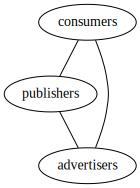

In [15]:
graphviz.Source(dot_graph)

* But retargeting and micro-targeting comes at huge privacy cost
* And doesn't even generate that much business value

## Current developments
* Safari, Firefox and Edge all rolled out 'intelligent tracking prevention'
* This helps protect privacy, but also totally breaks down advertising auctions
* And includes huge commercial interests: [Spotify antitrust complaint against Apple](https://www.theverge.com/2019/5/6/18530894/apple-music-monopoly-spotify-app-store-europe)
* Chromium open-source community has some very interessing ideas on how to apply differential privacy to browsers such that privacy is protected while advertising auctions are still possible. It's called [Privacy Sandbox](https://www.chromium.org/Home/chromium-privacy/privacy-sandbox).

## Final thoughts
* Unfortunately, differential privacy, or 'not having personal data' doesn't solve all issues
* Essentially, advertising and marketing in general is influencing consumer behavior

## Questions?

### I would like to thank the passengers of the Titanic
I don't think they have given consent for being part of this talk

In [16]:
!jupyter nbconvert differential_privacy.ipynb --to slides --post serve

[NbConvertApp] Converting notebook differential_privacy.ipynb to slides
[NbConvertApp] Writing 307385 bytes to differential_privacy.slides.html
[NbConvertApp] Redirecting reveal.js requests to https://cdnjs.cloudflare.com/ajax/libs/reveal.js/3.5.0
Serving your slides at http://127.0.0.1:8000/differential_privacy.slides.html
Use Control-C to stop this server
Opening in existing browser session.
^C

Interrupted
